In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.colors import LogNorm
import cv2
import os

Filename: IC3392_DESI_gi.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      28   (1024, 1024, 3)   float32   
SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                  -32 / number of bits per data pixel                  NAXIS   =                    3 / number of data axes                            NAXIS1  =                 1024 / length of data axis 1                          NAXIS2  =                 1024 / length of data axis 2                          NAXIS3  =                    3 / length of data axis 3                          EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H SURVEY  = 'LegacySurvey'                                                        VERSION = 'DR9     '                 

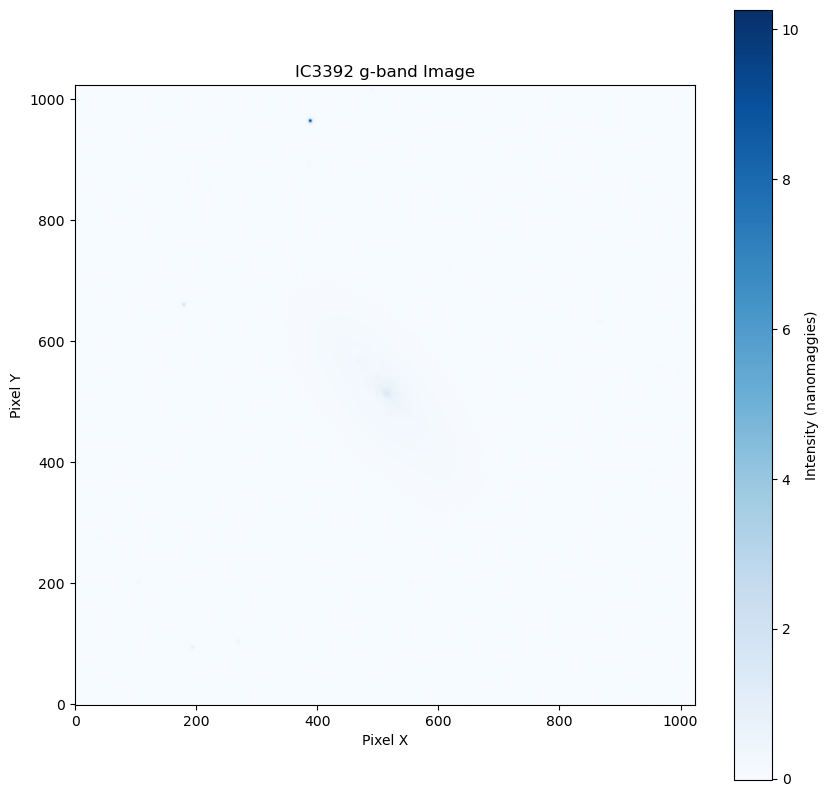

In [2]:
# Load the FITS file (update the filename as needed)
filename = "IC3392_DESI_gi.fits"
object_name = filename.split('_')[0]
hdul = fits.open(filename)

# Display the structure of the FITS file
hdul.info()

# Assuming the image data is in the primary HDU (index 0)
data = hdul[0].data

# Optionally, print header information to see details about the observation
header = hdul[0].header
print(header)

# Close the FITS file after loading data (optional but recommended)
hdul.close()

# Plot the data using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(data[0], cmap='Blues', origin='lower')
plt.colorbar(label='Intensity (nanomaggies)')
plt.title(f"{object_name} g-band Image")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

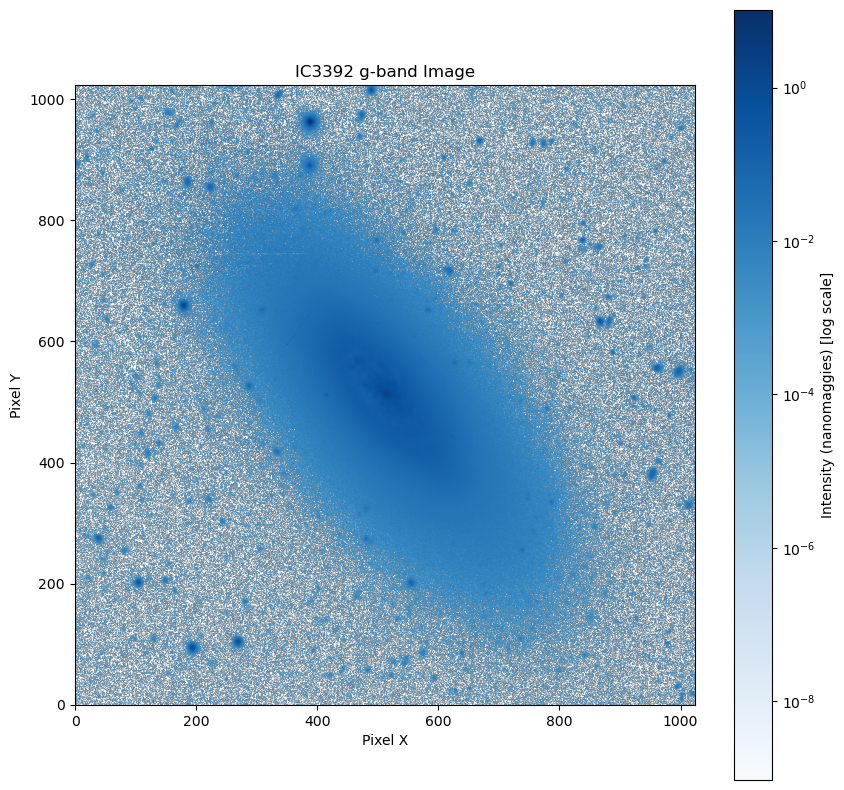

In [3]:
plt.figure(figsize=(10, 10))
# use only positive values for log scaling
vmin = data[0][data[0] > 0].min()
vmax = data[0].max()
im = plt.imshow(data[0], cmap='Blues', origin='lower',
                norm=LogNorm(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(im)
cbar.set_label('Intensity (nanomaggies) [log scale]')

plt.title(f"{object_name} g-band Image")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

In [4]:
# g-band isophotal threshold: 24.5 mag/arcsec^2
# with the pixel scale of 0.262 arcsec/pixel
# Convert to nanomaggies
g_band_limit = 24.5
pixel_scale = 0.262  # arcsec/pixel
# Convert mag/arcsec^2 to nanomaggies
# conversion from linear fluxes to magnitudes is 𝑚=22.5−2.5log10(flux)
def mag_to_nanomaggies(mag):
    return 10 ** ((22.5 - mag) / 2.5)
g_band_threshold = mag_to_nanomaggies(g_band_limit) * pixel_scale ** 2
print(f"g-band threshold in nanomaggies: {g_band_threshold:.8f}")

# i-band isophotal threshold: 24.5 mag/arcsec^2
# with the pixel scale of 0.262 arcsec/pixel
# Convert to nanomaggies
i_band_limit = 23.5
# Convert mag/arcsec^2 to nanomaggies
def mag_to_nanomaggies(mag):
    return 10 ** ((22.5 - mag) / 2.5)
i_band_threshold = mag_to_nanomaggies(i_band_limit) * pixel_scale ** 2
print(f"i-band threshold in nanomaggies: {i_band_threshold:.8f}")

g-band threshold in nanomaggies: 0.01087934
i-band threshold in nanomaggies: 0.02732767


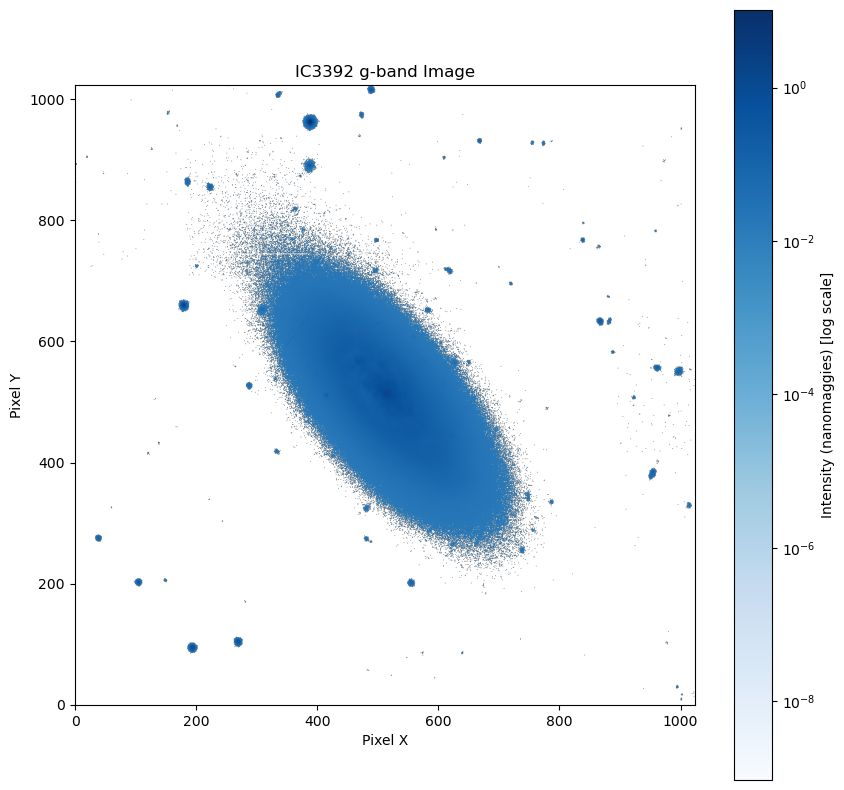

In [5]:
plt.figure(figsize=(10, 10))
# use only positive values for log scaling
vmin = data[0][data[0] > 0].min()
vmax = data[0].max()
im = plt.imshow(np.where(data[0] > g_band_threshold, data[0], 0), 
                cmap='Blues', origin='lower', norm=LogNorm(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(im)
cbar.set_label('Intensity (nanomaggies) [log scale]')

plt.title(f"{object_name} g-band Image")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

In [6]:
# nanomaggies to mag conversion
def nanomaggies_to_mag(nanomaggies):
    return 22.5 - 2.5 * np.log10(nanomaggies)
# Check the min and max values in the data
print("Min and max values in the data:")
print("g-band: ", nanomaggies_to_mag(data[0][data[0] > 0].min()), nanomaggies_to_mag(data[0].max()))
print("i-band: ", nanomaggies_to_mag(data[1][data[1] > 0].min()), nanomaggies_to_mag(data[1].max()))

Min and max values in the data:
g-band:  45.06492 19.972336
i-band:  43.191166 19.26295


In [7]:
# Calculate the total flux higher than isophotal threahold in g-band and i-band
g_band_isophotal_flux = np.sum(data[0][data[0] > g_band_threshold])
i_band_isophotal_flux = np.sum(data[1][data[1] > i_band_threshold])
print(f"Total g-band isophotal flux: {g_band_isophotal_flux:.8f} nanomaggies")      
print(f"Total i-band isophotal flux: {i_band_isophotal_flux:.8f} nanomaggies")

# Total g-band isophotal flux in mag
# Convert to magnitudes
def nanomaggies_to_mag(flux):
    return 22.5 - 2.5 * np.log10(flux)
g_band_isophotal_mag = nanomaggies_to_mag(g_band_isophotal_flux)
print(f"Total g-band isophotal magnitude: {g_band_isophotal_mag:.8f} mag")
# Total i-band isophotal flux in mag
i_band_isophotal_mag = nanomaggies_to_mag(i_band_isophotal_flux)
print(f"Total i-band isophotal magnitude: {i_band_isophotal_mag:.8f} mag")
# Calculate the g-i color index
g_i_magnitude_isophotal = g_band_isophotal_mag - i_band_isophotal_mag
print(f"Total g-i magnitude: {g_i_magnitude_isophotal:.8f} mag")

# Assume 16.5Mpc to get i-band absolute magnitude
# Use the distance modulus formula to calculate absolute magnitude
# formula: M = m - 5 * log10(d) + 5
distance_modulus = 5 * np.log10(16.5 * 1e6 / 10)  # distance in parsecs
i_abs_magnitude_isophotal = i_band_isophotal_mag - distance_modulus
print(f"Distance modulus: {distance_modulus:.8f} mag")
print(f"Absolute i-band magnitude: {i_abs_magnitude_isophotal:.8f} mag")

# Use g-i magnitude to calculate the total stellar mass
# formula: log10(M/Msun) = 1.15+0.7*(g-i)-0.4*M_i
total_stellar_mass_isophotal = 10 ** (1.15 + 0.7 * g_i_magnitude_isophotal - 0.4 * i_abs_magnitude_isophotal)
print(f"Total stellar mass: {total_stellar_mass_isophotal:.2e} Msun, or log10(M/Msun) = {np.log10(total_stellar_mass_isophotal):.2f}")


Total g-band isophotal flux: 8745.49804688 nanomaggies
Total i-band isophotal flux: 16758.25585938 nanomaggies
Total g-band isophotal magnitude: 12.64553833 mag
Total i-band isophotal magnitude: 11.93942642 mag
Total g-i magnitude: 0.70611191 mag
Distance modulus: 31.08741972 mag
Absolute i-band magnitude: -19.14799330 mag
Total stellar mass: 2.01e+09 Msun, or log10(M/Msun) = 9.30


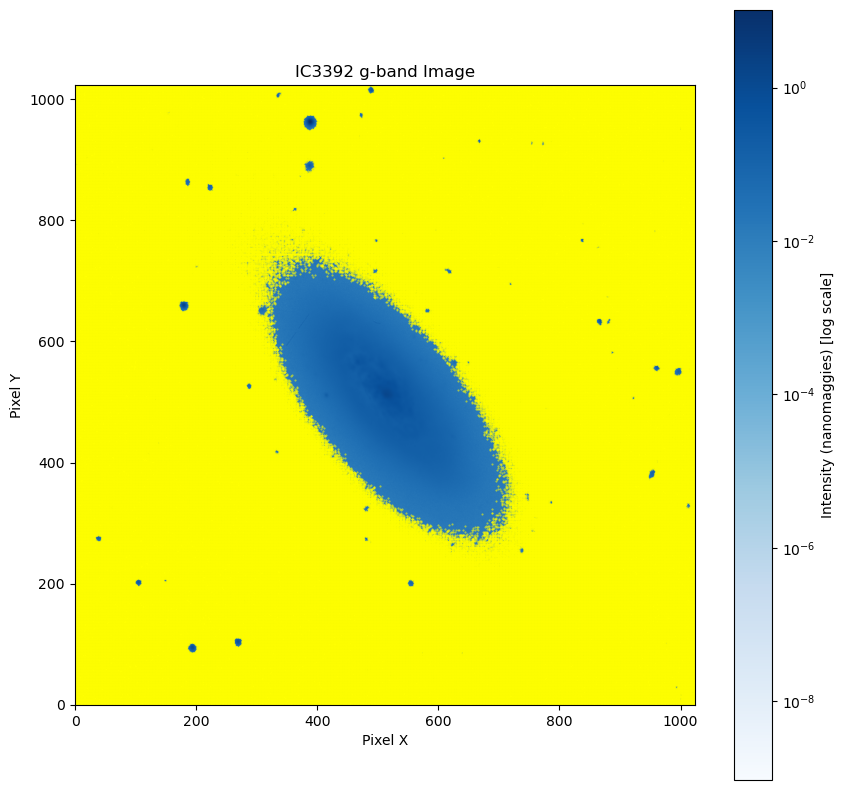

In [8]:
plt.figure(figsize=(10, 10))
# use only positive values for log scaling
vmin = data[0][data[0] > 0].min()
vmax = data[0].max()
im = plt.imshow(data[0], cmap='Blues', origin='lower',
                norm=LogNorm(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(im)
cbar.set_label('Intensity (nanomaggies) [log scale]')

# highlight all negative pixels in yellow
ys, xs = np.where(data[0] < g_band_threshold)
plt.scatter(xs, ys, s=1, c='yellow', alpha=0.6, marker='.')

plt.title(f"{object_name} g-band Image")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

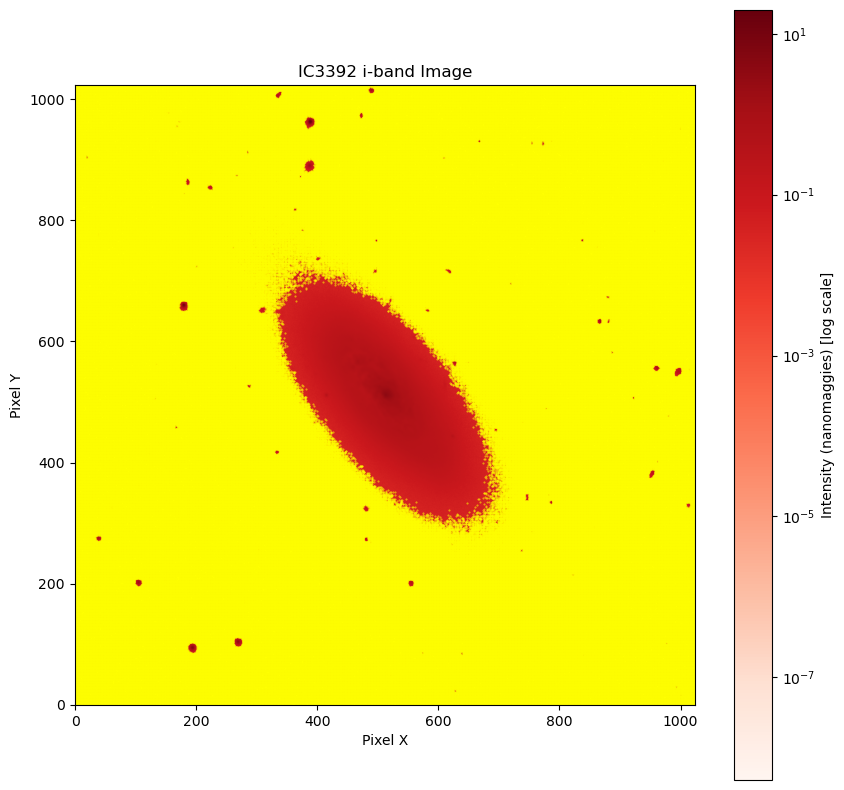

In [9]:
plt.figure(figsize=(10, 10))
# use only positive values for log scaling
vmin = data[1][data[1] > 0].min()
vmax = data[1].max()
im = plt.imshow(data[1], cmap='Reds', origin='lower',
                norm=LogNorm(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(im)
cbar.set_label('Intensity (nanomaggies) [log scale]')

# highlight all negative pixels in yellow
ys, xs = np.where(data[1] < i_band_threshold)
plt.scatter(xs, ys, s=1, c='yellow', alpha=0.6, marker='.')

plt.title(f"{object_name} i-band Image")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

Temporary image IC3392_g-band.png saved.


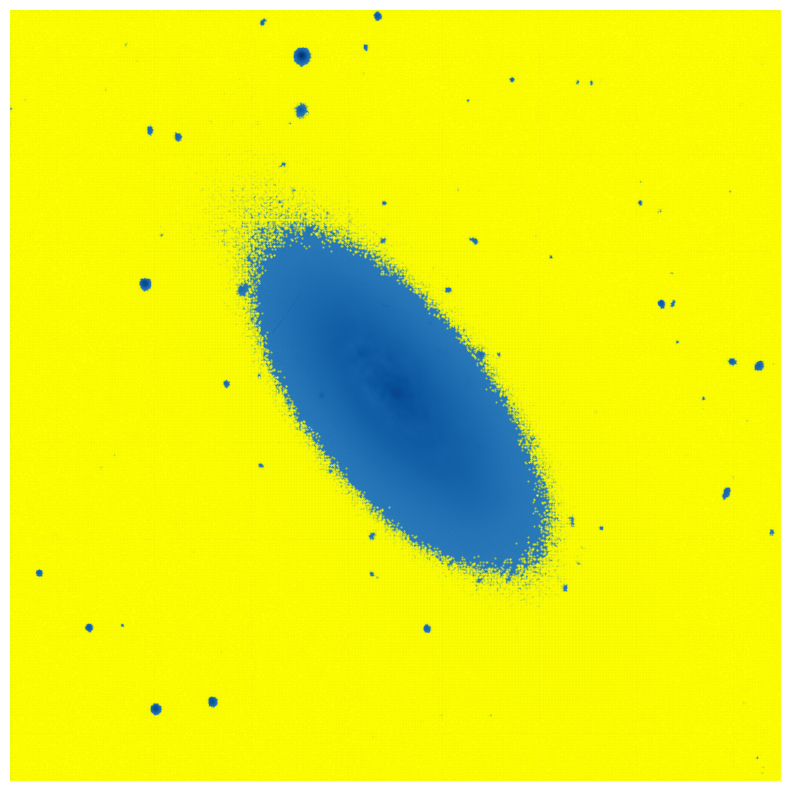

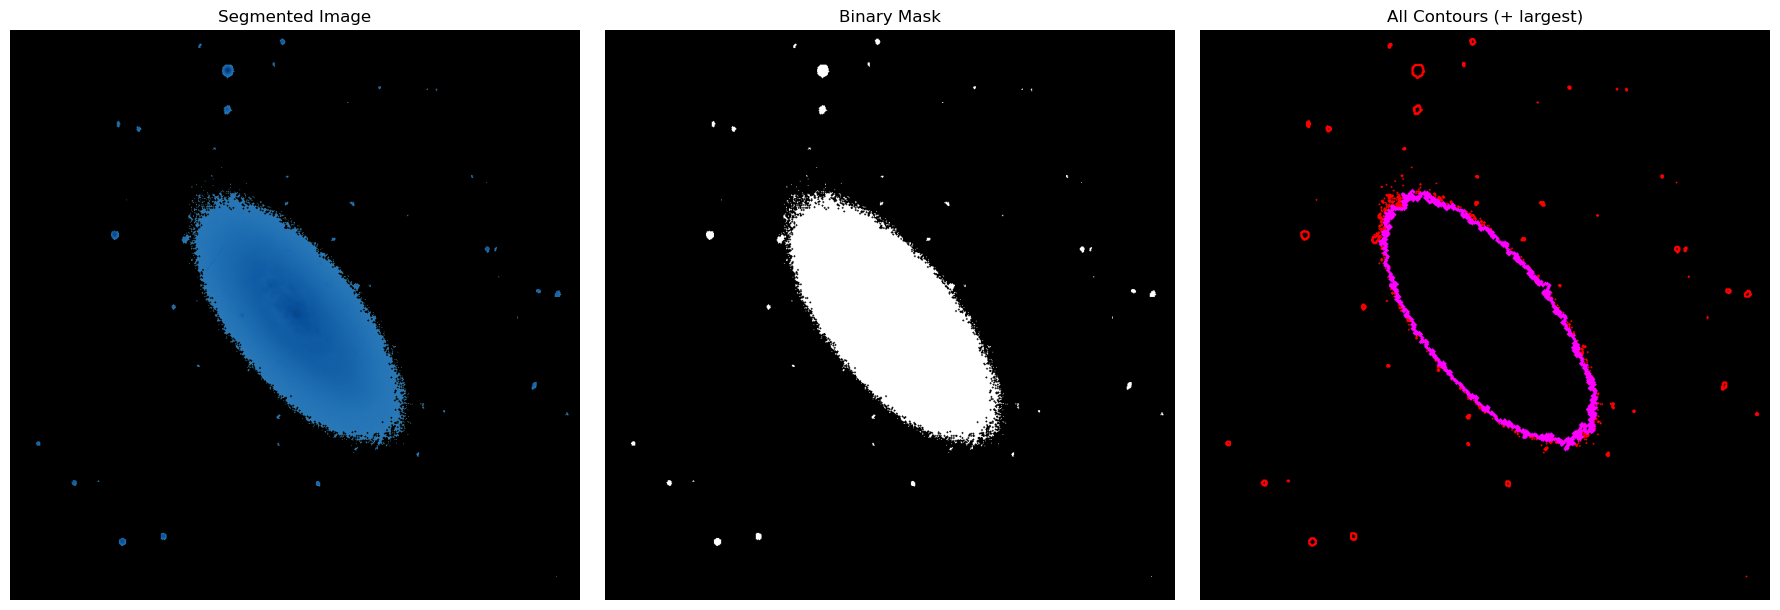

Found 267 contours; largest has area = 55502.0
Deleted temporary file IC3392_g-band.png


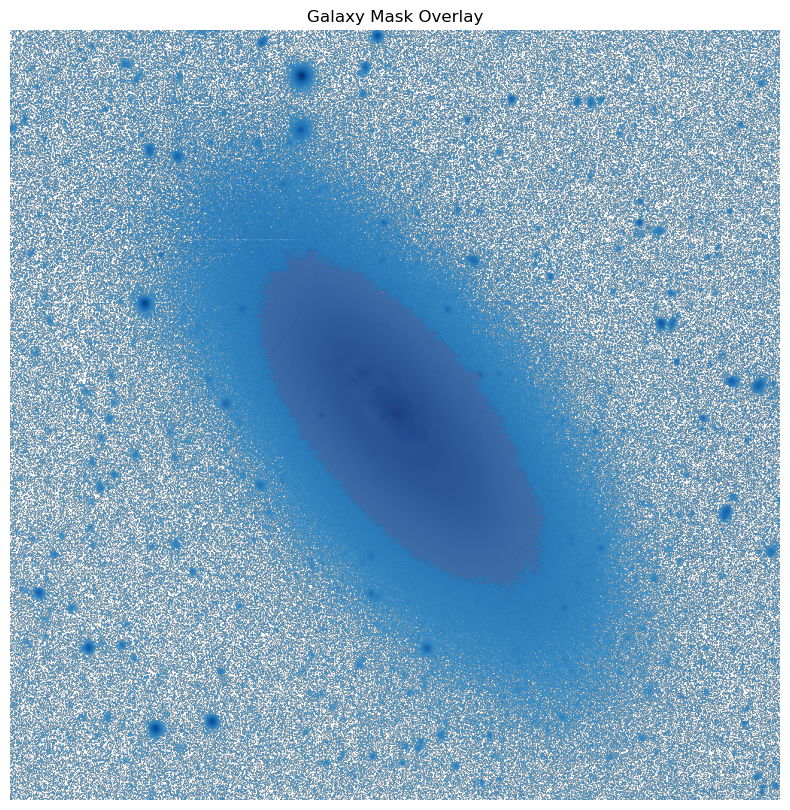

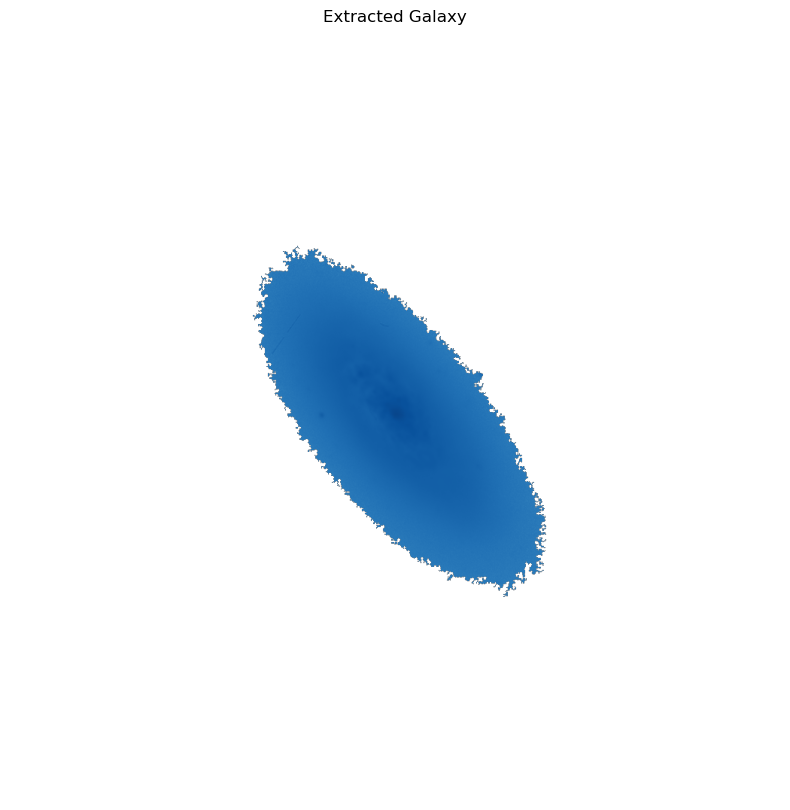

In [10]:
plt.figure(figsize=(10, 10))
vmin = data[0][data[0] > 0].min()
vmax = data[0].max()
plt.imshow(data[0], cmap='Blues', origin='lower',
           norm=LogNorm(vmin=vmin, vmax=vmax))
# highlight all negative pixels in yellow
ys, xs = np.where(data[0] < g_band_threshold)
plt.scatter(xs, ys, s=1, c='yellow', alpha=0.6, marker='.')
plt.axis('off')
plt.savefig(f"{object_name}_g-band.png",
            # dpi=200,
            bbox_inches='tight',)
print(f"Temporary image {object_name}_g-band.png saved.")
plt.show()

'''
APPROACH:
This python code performs color-based segmentation using HSV color space, focusing on the Hue component
with additional filtering on Saturation and Value components.

The segmentation process follows these steps:
1. Color Space Conversion: Convert RGB image to HSV color space, which separates color information (Hue) 
   from illumination intensity (Value) and color purity (Saturation).
2. Thresholding: Create a binary mask where pixels with Hue values between the lower and upper thresholds 
   (and with Saturation and Value ≥ 100) are set to white (255) and the rest are set to black (0).
3. Mask Application: Apply the binary mask to the original image to extract only the color regions of interest.
4. Binarization: Convert the segmented image to a binary image using thresholding.
5. Erosion: Apply morphological erosion to remove small details from the foreground.
6. Morphological Closing: Apply morphological closing to remove small holes in the foreground objects.
7. Ellipse Extraction: Find contours and fit an ellipse to the largest contour to extract the galaxy shape.
'''

def segment_image(image_path, lower_hue, upper_hue):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read image at {image_path}")
        return None, None
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv,
                       np.array([lower_hue, 100, 100]),
                       np.array([upper_hue, 255, 255]))
    segmented = cv2.bitwise_and(img, img, mask=mask)
    return segmented, mask

def binarize_image(image):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
    return binary

def extract_ellipse(binary_image):
    contours, _ = cv2.findContours(binary_image,
                                   cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print("No contours found in the image")
        return None, None
    largest = max(contours, key=cv2.contourArea)
    if len(largest) < 5:
        print("Not enough points to fit an ellipse")
        return None, None 

if __name__ == "__main__":
    image_path = f"{object_name}_g-band.png"
    lower_hue, upper_hue = 83, 108

    segmented_image, mask = segment_image(image_path, lower_hue, upper_hue)
    if segmented_image is None:
        exit(1)

    # Binarize the mask
    binary_image = binarize_image(mask)

    # Draw all contours and highlight the largest
    contours, _ = cv2.findContours(binary_image,
                                   cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)
    contour_vis = np.zeros_like(segmented_image)
    cv2.drawContours(contour_vis, contours, -1, (0, 0, 255), 2)
    if contours:
        largest = max(contours, key=cv2.contourArea)
        cv2.drawContours(contour_vis, [largest], -1, (255, 0, 255), 3)

    # # Save results
    # cv2.imwrite("segmented_" + image_path, segmented_image)
    # cv2.imwrite("binary_" + image_path, binary_image)
    # cv2.imwrite("contours_" + image_path, contour_vis)

    # Display inline in the notebook
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    # segmented image (BGR → RGB)
    axes[0].imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Segmented Image")
    axes[0].axis("off")
    # binary mask
    axes[1].imshow(binary_image, cmap="gray")
    axes[1].set_title("Binary Mask")
    axes[1].axis("off")
    # contours overlay (BGR → RGB)
    axes[2].imshow(cv2.cvtColor(contour_vis, cv2.COLOR_BGR2RGB))
    axes[2].set_title("All Contours (+ largest)")
    axes[2].axis("off")
    plt.tight_layout()
    plt.show()

    print(f"Found {len(contours)} contours; largest has area = {cv2.contourArea(largest)}")
    try:
        os.remove(image_path)
        print(f"Deleted temporary file {image_path}")
    except OSError as e:
        print(f"Error deleting temporary file {image_path}: {e}")

# Extract the largest contour as a mask at the PNG resolution
mask_small = np.zeros_like(binary_image, dtype=np.uint8)
cv2.drawContours(mask_small, [largest], -1, 255, thickness=-1)

# Flip vertically to correct the top‐bottom inversion
mask_small = cv2.flip(mask_small, 0)

# Resize the mask back to the native FITS resolution
h_native, w_native = data[0].shape
galaxy_mask = cv2.resize(
    mask_small,
    (w_native, h_native),
    interpolation=cv2.INTER_NEAREST
)

# Apply the mask to the original data
galaxy = np.zeros_like(data[0])
galaxy[galaxy_mask > 0] = data[0][galaxy_mask > 0]

# Display the mask overlaid on the full image
plt.figure(figsize=(10,10))
plt.imshow(data[0], cmap='Blues', origin='lower',
           norm=LogNorm(vmin=vmin, vmax=vmax))
plt.imshow(np.ma.masked_where(galaxy_mask == 0, galaxy_mask),
           cmap='autumn', alpha=0.1, origin='lower')
plt.title('Galaxy Mask Overlay')
plt.axis('off')
plt.show()

# Display only the extracted galaxy
plt.figure(figsize=(10,10))
plt.imshow(galaxy, cmap='Blues', origin='lower',
           norm=LogNorm(vmin=vmin, vmax=vmax))
plt.title('Extracted Galaxy')
plt.axis('off')
plt.show()


Total g-band magnitude of IC3392: 12.77 AB


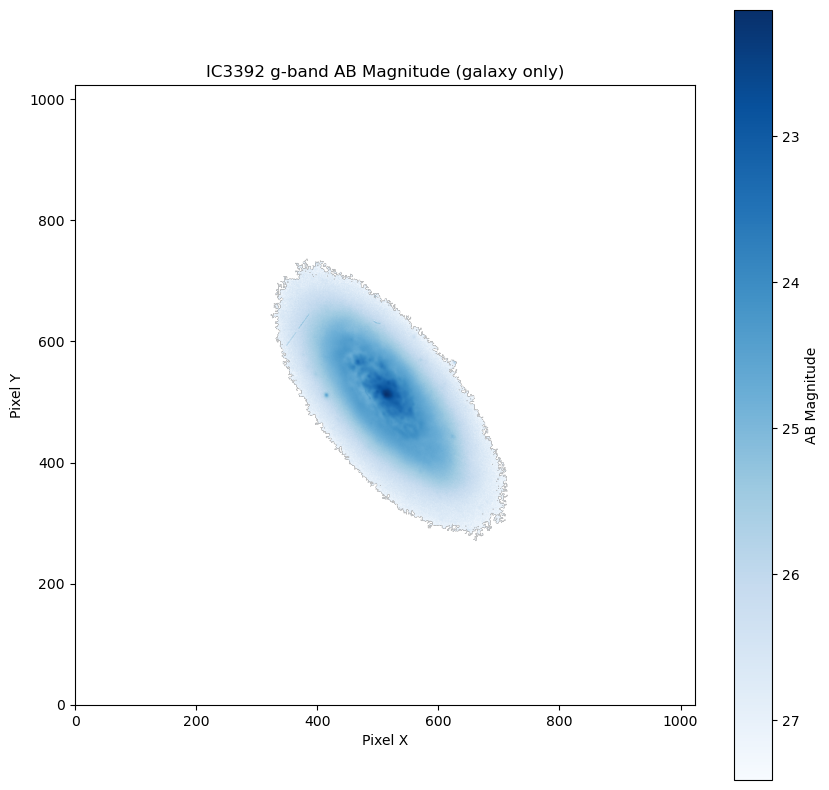

In [11]:
# Since the data shape is (2, 512, 512), extract the first slice for the g-band
g_band = data[0]

# Select only the galaxy pixels
mask = (galaxy_mask > 0) & (g_band > g_band_threshold)

# Compute AB magnitudes only inside the galaxy
m_ab = np.full(g_band.shape, np.nan)
m_ab[mask] = 22.5 - 2.5 * np.log10(g_band[mask])

# Total g-band magnitude
# Compute the total magnitude of the galaxy
total_magnitude = 22.5 - 2.5 * np.log10(np.sum(g_band[mask]))
print(f"Total g-band magnitude of {object_name}: {total_magnitude:.2f} AB")

# Plot galaxy AB‐magnitude map
plt.figure(figsize=(10, 10))
plt.imshow(m_ab, cmap='Blues_r', origin='lower')
cbar = plt.colorbar(label='AB Magnitude')
cbar.ax.invert_yaxis()
plt.title(f"{object_name} g-band AB Magnitude (galaxy only)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()


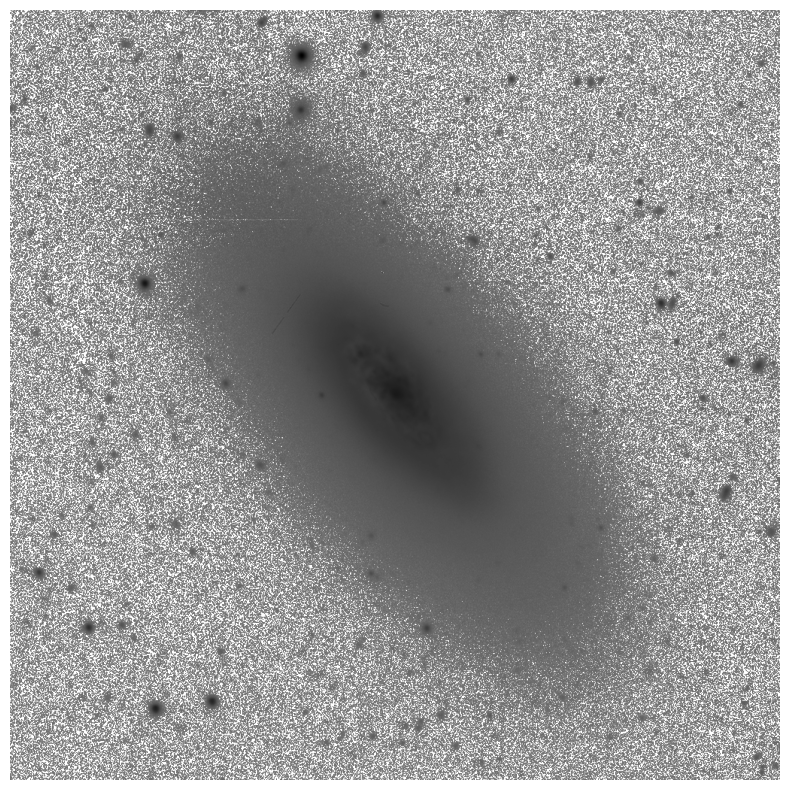

In [12]:
plt.figure(figsize=(10, 10))
# use only positive values for log scaling
vmin = data[0][data[0] > 0].min()
vmax = data[0].max()
im = plt.imshow(data[0], cmap='Grays', origin='lower',
                norm=LogNorm(vmin=vmin, vmax=vmax))
plt.axis('off')
plt.show()

In [13]:
header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                 1024 / length of data axis 1                          
NAXIS2  =                 1024 / length of data axis 2                          
NAXIS3  =                    3 / length of data axis 3                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
SURVEY  = 'LegacySurvey'                                                        
VERSION = 'DR9     '                                                            
IMAGETYP= 'IMAGE   '           / None                                           
BANDS   = 'grz     '        

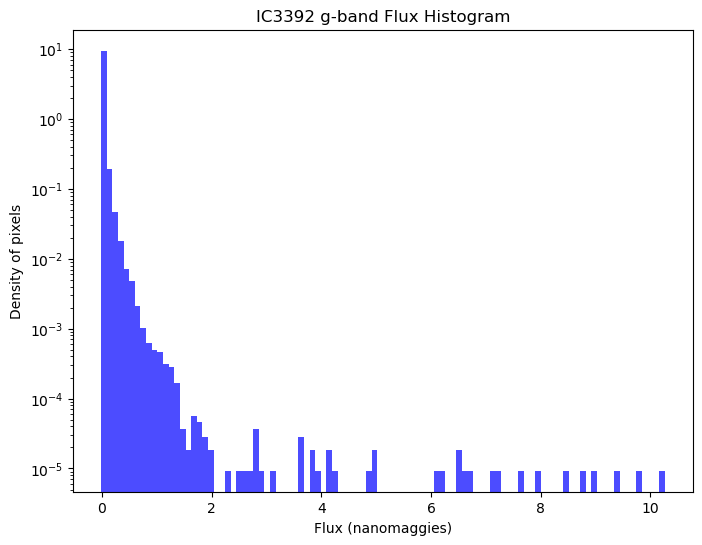

In [14]:
plt.figure(figsize=(8, 6))
plt.hist(g_band.ravel(), bins=100, color='blue', alpha=0.7, density=True)
plt.xlabel('Flux (nanomaggies)')
plt.ylabel('Density of pixels')
plt.title(f"{object_name} g-band Flux Histogram")
# plt.xscale('log')
plt.yscale('log')
plt.show()

Total i-band magnitude of IC3392: 12.04 AB


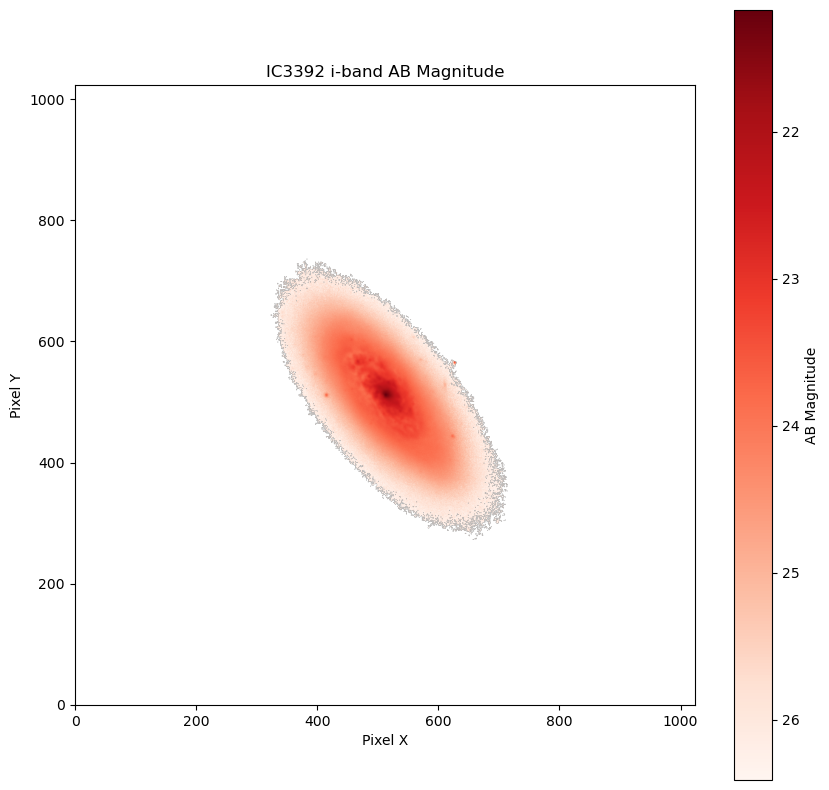

In [15]:
# Extract the second slice (i-band)
i_band = data[1]

# Convert flux to AB magnitudes
mask_i = (galaxy_mask > 0) & (i_band > i_band_threshold)
m_ab_i = np.full(i_band.shape, np.nan)
m_ab_i[mask_i] = 22.5 - 2.5 * np.log10(i_band[mask_i])

# Total i-band magnitude
total_magnitude_i = 22.5 - 2.5 * np.log10(np.sum(i_band[mask_i]))
print(f"Total i-band magnitude of {object_name}: {total_magnitude_i:.2f} AB")

# Plot the i-band in red
plt.figure(figsize=(10, 10))
plt.imshow(m_ab_i, cmap='Reds_r', origin='lower')
cbar = plt.colorbar(label='AB Magnitude')
cbar.ax.invert_yaxis()
plt.title(f"{object_name} i-band AB Magnitude")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()


In [16]:
# Universal distance lookup (in Mpc)
distance_lookup = {
    "IC3392": 13.65,
    "NGC4383": 16.60, 
    "NGC4501": 17.10, 
    "NGC4192": 13.55, 
}
# fallback to 16.5 Mpc (distance of Virgo, Mei et al. 2007) if object_name not in the dict
distance_mpc = distance_lookup.get(object_name, 16.50)
distance_pc = distance_mpc * 1e6
DM = 5 * np.log10(distance_pc / 10.0)

# Combine the valid g-band and i-band masks
mask_combined = mask & mask_i

# Compute absolute magnitude in i-band
M_i = m_ab_i - DM

# Compute g-i color
g_minus_i = m_ab - m_ab_i

# Estimate log(M_*)
log_mstar_individual = np.full(i_band.shape, np.nan)
log_mstar_individual[mask_combined] = 1.15 + 0.7 * g_minus_i[mask_combined] - 0.4 * M_i[mask_combined]

# Total stellar mass in solar masses
log_mstar_individual_total = np.nansum(10**log_mstar_individual[mask_combined])  # Sum over the valid pixels
print(f"Estimated total stellar mass in solar masses: {log_mstar_individual_total:.2e}, or log10({np.log10(log_mstar_individual_total):.2f})")

Estimated total stellar mass in solar masses: 1.36e+09, or log10(9.13)


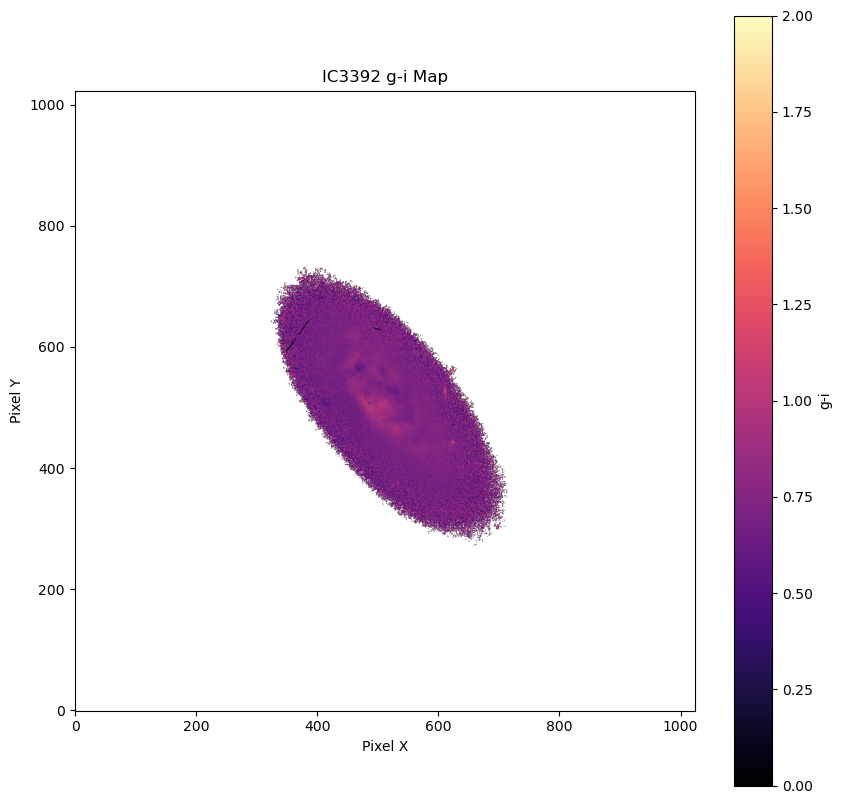

In [17]:
# Visualize the stellar mass distribution
plt.figure(figsize=(10, 10))
plt.imshow(g_minus_i, origin='lower', cmap='magma', vmin=0, vmax=2)
cbar = plt.colorbar(label='g-i')
plt.title(f"{object_name} g-i Map")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

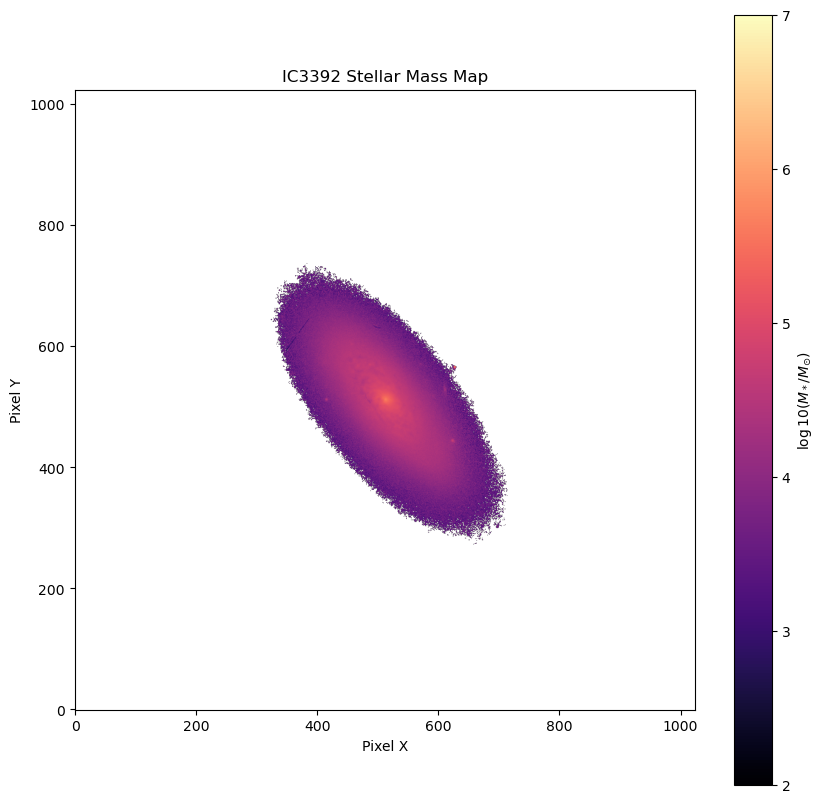

In [18]:
# Visualize the stellar mass distribution
plt.figure(figsize=(10, 10))
plt.imshow(log_mstar_individual, origin='lower', cmap='magma', vmin=2, vmax=7)
cbar = plt.colorbar(label=r'$\log{10}(M_*/M_{\odot})$')
plt.title(f"{object_name} Stellar Mass Map")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

In [19]:
# Sum the g-band flux
sum_g_flux = np.nansum(g_band[mask])

# Sum the i-band flux
sum_i_flux = np.nansum(i_band[mask_i])

# Convert these summed fluxes to total AB magnitudes
m_ab_g_total = 22.5 - 2.5 * np.log10(sum_g_flux)
m_ab_i_total = 22.5 - 2.5 * np.log10(sum_i_flux)

# Compute distance modulus and total absolute magnitude in g-band
M_g_total = m_ab_g_total - DM
# Compute distance modulus and total absolute magnitude in i-band
M_i_total = m_ab_i_total - DM

# Compute total g-i color
g_minus_i_total = m_ab_g_total - m_ab_i_total

# Estimate log(M_*), then convert to stellar mass
log_mstar_total = 1.15 + 0.7 * g_minus_i_total - 0.4 * M_i_total
mstar_total = 10**log_mstar_total

print(f"Alternative total stellar mass (integrated flux): {mstar_total:.2e}, or log10({np.log10(mstar_total):.2f}) solar masses")
print(f"Total g-band apparent magnitude: {m_ab_g_total:.2f}")
print(f"Total i-band apparent magnitude: {m_ab_i_total:.2f}")
print(f"Total g-band absolute magnitude: {M_g_total:.2f}")
print(f"Total i-band absolute magnitude: {M_i_total:.2f}")


Alternative total stellar mass (integrated flux): 1.31e+09, or log10(9.12) solar masses
Total g-band apparent magnitude: 12.77
Total i-band apparent magnitude: 12.04
Total g-band absolute magnitude: -17.91
Total i-band absolute magnitude: -18.64


In [20]:
# bin_factors = [1, 4, 16, 64, 256, 512, 1024]
# mass_results = {}

# def bin_image(image, bin_factor):
#     # image is HxW, bin_factor divides H,W
#     new_shape = (image.shape[0] // bin_factor, bin_factor,
#                  image.shape[1] // bin_factor, bin_factor)
#     return image.reshape(new_shape).sum(axis=(1, 3))

# mass_results = {}
# for bf in bin_factors:
#     # bin the combined mask (as int) to know which bins overlap the galaxy
#     mask_bin = bin_image(mask_combined.astype(int), bf) > 0

#     # Sum fluxes in each bin for g- and i-band
#     g_bin = bin_image(g_band, bf)
#     i_bin = bin_image(i_band, bf)

#     # Only keep bins inside the galaxy mask
#     valid = mask_bin & (g_bin > 0) & (i_bin > 0)

#     # Convert to magnitudes
#     g_bin_m = np.full_like(g_bin, np.nan)
#     i_bin_m = np.full_like(i_bin, np.nan)
#     g_bin_m[valid] = 22.5 - 2.5 * np.log10(g_bin[valid])
#     i_bin_m[valid] = 22.5 - 2.5 * np.log10(i_bin[valid])

#     # Compute absolute i-band, g-i color, and mass
#     M_i_binned = i_bin_m - DM
#     g_minus_i_binned = g_bin_m - i_bin_m
#     log_mstar_binned = np.full_like(i_bin_m, np.nan)
#     log_mstar_binned[valid] = (1.15 +
#                                0.7 * g_minus_i_binned[valid] -
#                                0.4 * M_i_binned[valid])

#     # Total stellar mass for this bin factor
#     total_mass = np.nansum(10**log_mstar_binned[valid])
#     mass_results[bf] = total_mass

#     print(f"Binning {bf}×{bf} -> total stellar mass: {total_mass:.2e}")


Binned mass @ 4×4 = 1.36e+09 > previous 1.36e+09 or < true total 1.31e+09
→ fallback to true total mass (log10 M⊙): 9.12


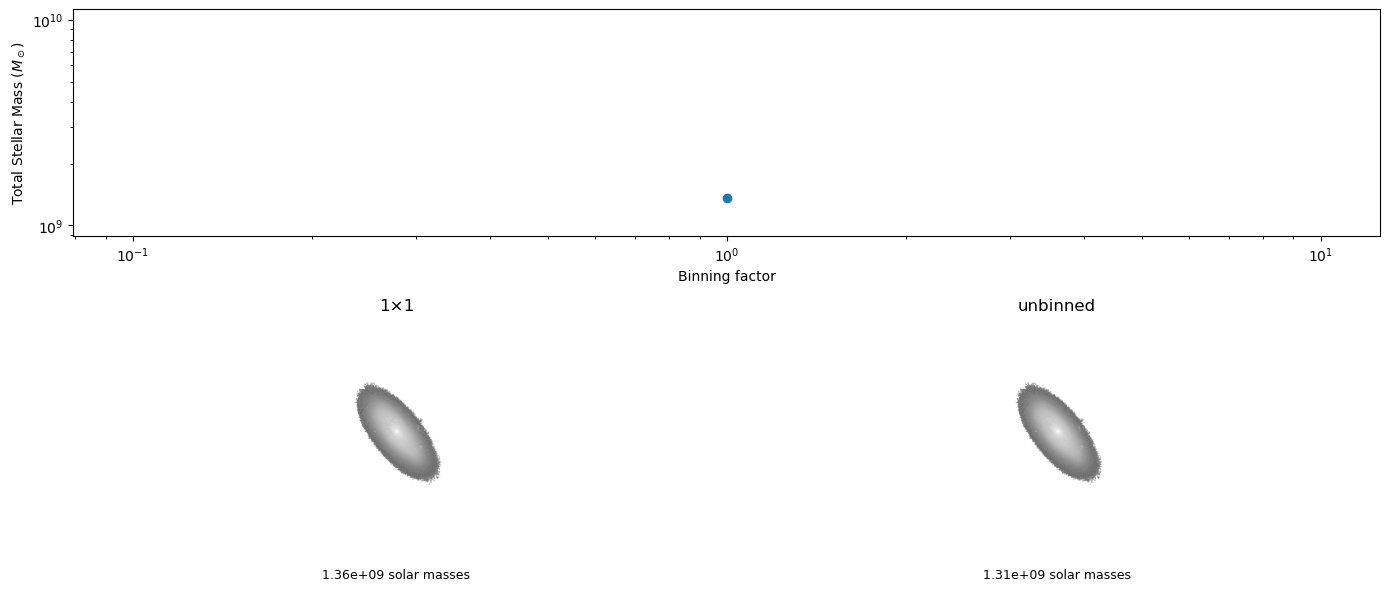

In [23]:
# clear previous results
mass_values = []
mass_maps   = []
prev_mass   = None

bin_factors = [1, 4, 16, 64, 256, 512, 1024,]

def bin_image(image, bin_factor):
    # crop so height and width are multiples of bin_factor
    h, w = image.shape[:2]
    h2 = h - (h % bin_factor)
    w2 = w - (w % bin_factor)
    img = image[:h2, :w2]
    # reshape into blocks and sum
    return img.reshape(h2//bin_factor, bin_factor, w2//bin_factor, bin_factor).sum(axis=(1,3))

for bf in bin_factors:
    mask_bin = bin_image(mask_combined.astype(int), bf) > 0
    g_bin    = bin_image(g_band, bf)
    i_bin    = bin_image(i_band, bf)
    valid    = mask_bin & (g_bin>0) & (i_bin>0)
    g_bin_m  = np.full_like(g_bin, np.nan, dtype=float)
    i_bin_m  = np.full_like(i_bin, np.nan, dtype=float)
    g_bin_m[valid] = 22.5 - 2.5*np.log10(g_bin[valid])
    i_bin_m[valid] = 22.5 - 2.5*np.log10(i_bin[valid])
    M_i_binned = i_bin_m - DM
    gi         = g_bin_m - i_bin_m
    log_mstar_binned = np.full_like(i_bin_m, np.nan, dtype=float)
    log_mstar_binned[valid] = 1.15 + 0.7*gi[valid] - 0.4*M_i_binned[valid]
    total_mass = np.nansum(10**log_mstar_binned[valid])
    if (prev_mass is not None and total_mass > prev_mass) or (total_mass < mstar_total):
        print(f"Binned mass @ {bf}×{bf} = {total_mass:.2e} "
              f"> previous {prev_mass:.2e} or < true total {mstar_total:.2e}")
        print(f"→ fallback to true total mass (log10 M⊙): {log_mstar_total:.2f}")
        break
    mass_values.append(total_mass)
    mass_maps.append(log_mstar_binned)
    prev_mass = total_mass

# now plot only the successful bins  
fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(bin_factors[:len(mass_values)], mass_values, "o-")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("Binning factor")
ax1.set_ylabel(r"Total Stellar Mass ($M_\odot$)")

# show each mass map with its total mass underneath
n = len(mass_values)
for i, bf in enumerate(bin_factors[:n]):
    ax = fig.add_subplot(2, n+1, n + i + 2)
    ax.imshow(mass_maps[i], origin="lower", cmap="Greys_r")
    ax.set_title(f"{bf}×{bf}")
    ax.axis("off")
    # annotate the total mass for this bin
    ax.text(
        0.5, -0.1,
        f"{mass_values[i]:.2e} solar masses",
        transform=ax.transAxes,
        ha="center", va="top",
        fontsize=9
    )

# add unbinned full‐resolution map at the rightmost slot in the lower row
axu = fig.add_subplot(2, n+1, 2*(n+1))
axu.imshow(log_mstar_individual, origin="lower", cmap="Greys_r")
axu.set_title("unbinned")
axu.axis("off")
# annotate the unbinned mass
axu.text(
    0.5, -0.1,
    f"{mstar_total:.2e} solar masses",
    transform=axu.transAxes,
    ha="center", va="top",
    fontsize=9
)

plt.tight_layout()
plt.show()